# Chargement des données

In [1]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import codecs
import re
import os.path
import string
import unicodedata
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import sklearn.naive_bayes as nb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm, linear_model
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, average_precision_score
from sklearn.feature_extraction.text import CountVectorizer
import itertools
from sklearn.linear_model import LogisticRegression


In [2]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

fname = "/Users/etienneperez/Documents/IODAA/TAL/ressources/AFDpresidentutf8/corpus.tache1.learn.utf8"

alltxts,alllabs = load_pres(fname)

# Description des données

In [3]:
# Nombre de phrase
print("Nombre de phrase : ", len(alltxts))

# Mise en évidénce du cas déséquilibré
print("Nombre d'étiquettes 1 : ", alllabs.count(1), " (",round(alllabs.count(1)/len(alllabs),2),")")
print("Nombre d'étiquettes -1 : ", alllabs.count(-1), " (",round(alllabs.count(-1)/len(alllabs),2),")")

Nombre de phrase :  57413
Nombre d'étiquettes 1 :  49890  ( 0.87 )
Nombre d'étiquettes -1 :  7523  ( 0.13 )


In [4]:
# Fonctions de prétraitements basiques

# Supprimer la ponctuation et les chiffres de toutes les phrases
def suppr_ponct(txt): # prend alltxts en entrée
    punc = string.punctuation  
    punc += '\n\r\t'

    for i in range(len(txt)):
        txt[i] = txt[i].translate(str.maketrans(punc, ' ' * len(punc)))  
        txt[i] = re.sub('[0-9]+', '', txt[i])

# Supprimer les accents et caractères spéciaux
def suppr_accents_maj(txt): # prend alltxts en entrée
    for i in range(len(txt)):
        txt[i] = unicodedata.normalize('NFD',  txt[i]).encode('ascii', 'ignore').decode("utf-8")
        txt[i] =  txt[i].lower()

In [5]:
# Génération du dictionnaire {"mot" : occurence_documentaire}
suppr_ponct(alltxts)
suppr_accents_maj(alltxts)

words = []
for i in range(len(alltxts)):
    mots_vus = []
    for mot in alltxts[i].split():
        if mot not in mots_vus: # on ajoute 1 seule fois le mot s'il apparait dans la phrase --> occurence documentaire et pas totale
            words.append(mot)
            mots_vus.append(mot)


from collections import Counter

dico = Counter(words)

# Dico qui associe 1 mot à sa position dans le dictionnaire dico
trans = dict(zip(list(dico.keys()), np.arange(len(dico)).tolist()))

# Extraction du vocabulaire

In [6]:
# Extraction du vocabulaire
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(alltxts)

print("Taille du vocabulaire : ",len(vectorizer.get_feature_names()))


27054


[('de', 35268), ('la', 27664), ('et', 26298), ('l', 24658), ('a', 23599), ('le', 19625), ('les', 18229), ('d', 16258), ('des', 16088), ('est', 14927), ('en', 13349), ('que', 13140), ('qui', 12395), ('un', 10791), ('une', 10692), ('dans', 10113), ('pour', 9892), ('du', 8966), ('il', 8861), ('je', 8808), ('nous', 7696), ('au', 7269), ('c', 7248), ('vous', 7140), ('ce', 6990), ('plus', 5882), ('pas', 5704), ('qu', 5551), ('sur', 5223), ('s', 5094), ('notre', 5063), ('france', 4937), ('ne', 4890), ('par', 4849), ('cette', 4558), ('mais', 4388), ('avec', 4345), ('aussi', 4232), ('se', 4163), ('nos', 4138), ('pays', 4126), ('ou', 4122), ('sont', 4104), ('elle', 3848), ('n', 3759), ('ont', 3641), ('aux', 3615), ('etre', 3608), ('tout', 3453), ('tous', 3247), ('j', 3163), ('votre', 3059), ('leur', 2994), ('y', 2991), ('son', 2834), ('bien', 2821), ('nom', 2755), ('ces', 2712), ('meme', 2692), ('comme', 2642), ('hui', 2558), ('aujourd', 2557), ('on', 2497), ('entre', 2476), ('doit', 2389), ('eu

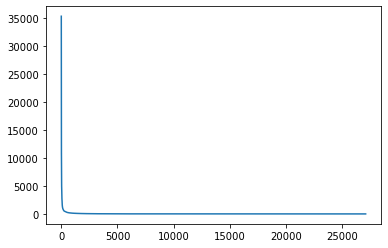

In [8]:
# Affichage des 100 mots les plus apparus dans les phrases
print("100 mots les plus apparus : ",dico.most_common(100))
freq = [f for w,f in dico.most_common()]

plt.plot(freq)

# Transformation paramétrique du texte

In [94]:
# DEFINITION DES FONCTIONS DE PRETRAITEMENT

# Data augmentation pour rééquilibrer les classes
def data_augmentation(txt,labs):
    liste_positions = []
    for i in labs:
        liste_positions.append(i == 1) 

    liste_classe_minoritaire = itertools.compress(txt, liste_positions)

    txts_bis = []
    for each in liste_classe_minoritaire:
        txts_bis.append(each)

    for elem in txts_bis: # nombre d'ajout trouvé de manière empirique pour avoir environ 50/50
        txt.append(elem)
        txt.append(elem)
        txt.append(elem)
        txt.append(elem)
        txt.append(elem)
        labs.append(1)
        labs.append(1)
        labs.append(1)
        labs.append(1)
        labs.append(1)

# Stemming
def stemming(txt):
    ps = PorterStemmer()
    compteur = 0
    for sentence in txt:
        # print("sentence : ",sentence)
        words = word_tokenize(sentence,language='french')
        # print("words : ",words)
        sentence_new = ''
        for word in words:
            word_new = ps.stem(word)
            sentence_new += word_new + ' '
        txt[compteur] = sentence_new
        compteur += 1

# Stopword
stop_words = stopwords.words('french')



In [95]:
# MISE EN PLACE DES PRETRAITEMENTS --> GENERATION DE DIFFERENTS JEUX DE DONNEES
# Résumé : pour chaque type de traitement du cas déséquilibré (data augmentation ou pénalisation erreur classe min), on génère 3 jeux de données issus de
# 3 prétraitrements différents : prétaitements basiques + stop words + stemming, n-gram niveau mots, n-gram niveau caractères

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(alltxts, alllabs, test_size=0.3, random_state=0)

# On inverse les étiquettes 1 et -1 pour que la classe minoritaire soit étiquetée +1
# Cela permet de considérer la classe minoritaire comme la classe d'intérêt dans les métriques de scoring de gridSearchCV
for i in range(0,len(y_train)):
    if y_train[i] == -1:
        y_train[i] = 1
    else:
        y_train[i] = -1

for i in range(0,len(y_test_1)):
    if y_test[i] == -1:
        y_test[i] = 1
    else:
        y_test[i] = -1

# On ajoute à liste_donnees différents jeux de données issus de différents pré-traitements
liste_donnees = []

# Prétraitement par stemming commun à tous les jeux de données
stemming(X_train)
stemming(X_test)

#######################################
# PRETRAITEMENTS SANS DATA AUGMENTATION
#######################################
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()
y_train_1 = y_train.copy()
y_test_1 = y_test.copy()

# Prétraitement avec pré-traitements basiques + stop words + stemming
vectorizer = CountVectorizer(stop_words = stop_words, min_df = 2)
X_train_vec = vectorizer.fit_transform(X_train_1)
X_test_vec = vectorizer.transform(X_test_1)
liste_donnees.append([X_train_vec,y_train_1,X_test_vec,y_test_1,len(vectorizer.get_feature_names()), "Prétraitements basiques + stopwords + stemming : "])

# Prétraitement avec bigram et trigram au niv mot (+ pré-traitements basiques + stop words + stemming)
vectorizer = CountVectorizer(stop_words = stop_words, ngram_range=(1,3), analyzer='word', min_df = 2)
X_train_vec = vectorizer.fit_transform(X_train_1)
X_test_vec = vectorizer.transform(X_test_1)
liste_donnees.append([X_train_vec,y_train_1,X_test_vec,y_test_1,len(vectorizer.get_feature_names()), "Prétraitements basiques + stopwords + stemming + bigram/trigram niveau mot : "])

# Prétraitement avec bigram et trigram au niv caractère (+ pré-traitements basiques + stop words + stemming)
vectorizer = CountVectorizer(stop_words = stop_words,ngram_range=(2,4), analyzer='char', min_df = 2)
X_train_vec = vectorizer.fit_transform(X_train_1)
X_test_vec = vectorizer.transform(X_test_1)
liste_donnees.append([X_train_vec,y_train_1,X_test_vec,y_test_1,len(vectorizer.get_feature_names()), "Prétraitements basiques + stopwords + stemming + bigram/trigram niveau caractère: "])

#######################################
# PRETRAITEMENTS AVEC DATA AUGMENTATION
#######################################
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
y_train_2 = y_train.copy()
y_test_2 = y_test.copy()
data_augmentation(X_train_2,y_train_2)

# Prétraitement avec pré-traitements basiques + stop words + stemming
vectorizer = CountVectorizer(stop_words = stop_words, min_df = 2)
X_train_vec = vectorizer.fit_transform(X_train_2)
X_test_vec = vectorizer.transform(X_test_2)
liste_donnees.append([X_train_vec,y_train_2,X_test_vec,y_test_2,len(vectorizer.get_feature_names()), "Prétraitements basiques + stopwords + stemming + data augmentation : "])

# Prétraitement avec data augmentation (+ pré-traitements basiques + stop words + stemming + bigram et trigram au niv mot)
vectorizer = CountVectorizer(stop_words = stop_words, ngram_range=(1,3), analyzer='word', min_df = 2)
X_train_vec = vectorizer.fit_transform(X_train_2)
X_test_vec = vectorizer.transform(X_test_2)
liste_donnees.append([X_train_vec,y_train_2,X_test_vec,y_test_2,len(vectorizer.get_feature_names()), "Prétraitements basiques + stopwords + stemming + data augmentation + bigram/trigram niveau mot : "])

# Prétraitement avec data augmentation (+ pré-traitements basiques + stop words + stemming + bigram et trigram au niv caractère)
vectorizer = CountVectorizer(stop_words = stop_words, ngram_range=(2,4), analyzer='char', min_df = 2)
X_train_vec = vectorizer.fit_transform(X_train_2)
X_test_vec = vectorizer.transform(X_test_2)
liste_donnees.append([X_train_vec,y_train_2,X_test_vec,y_test_2,len(vectorizer.get_feature_names()), "Prétraitements basiques + stopwords + stemming + data augmentation + bigram/trigram niveau carac : "])


In [96]:
# Vérification que la classe minoritaire est bien étiquetée +1
print("Nombre d'étiquettes 1 - y_train_1: ", liste_donnees[0][1].count(1), " (",round( liste_donnees[0][1].count(1)/len( liste_donnees[0][1]),2),")")
print("Nombre d'étiquettes -1 - y_train_1: ",  liste_donnees[0][1].count(-1), " (",round( liste_donnees[0][1].count(-1)/len( liste_donnees[0][1]),2),")")

print("Nombre d'étiquettes 1 - y_test_1: ", liste_donnees[0][3].count(1), " (",round( liste_donnees[0][3].count(1)/len( liste_donnees[0][3]),2),")")
print("Nombre d'étiquettes -1 - y_test_1: ",  liste_donnees[0][3].count(-1), " (",round( liste_donnees[0][3].count(-1)/len( liste_donnees[0][3]),2),")")

Nombre d'étiquettes 1 - y_train_1:  5243  ( 0.13 )
Nombre d'étiquettes -1 - y_train_1:  34946  ( 0.87 )
Nombre d'étiquettes 1 - y_test_1:  2280  ( 0.13 )
Nombre d'étiquettes -1 - y_test_1:  14944  ( 0.87 )


In [97]:
# Vérification du rééquilibrage des classes par data augmentation pour les 3 derniers jeux de données
print("Nombre d'étiquettes 1 - y_train : ", y_train_2.count(1), " (",round(y_train_2.count(1)/len(y_train_2),2),")")
print("Nombre d'étiquettes -1 - y_train : ", y_train_2.count(-1), " (",round(y_train_2.count(-1)/len(y_train_2),2),")")

Nombre d'étiquettes 1 - y_train :  31458  ( 0.47 )
Nombre d'étiquettes -1 - y_train :  34946  ( 0.53 )


In [98]:
# Taille du vocabulaire des données issues des différents pré-traitements
for liste in liste_donnees:
    print(liste[5])
    print("Taille vocab : ",liste[4])

Prétraitements basiques + stopwords + stemming : 
Taille vocab :  10028
Prétraitements basiques + stopwords + stemming + bigram/trigram niveau mot : 
Taille vocab :  89909
Prétraitements basiques + stopwords + stemming + bigram/trigram niveau caractère: 
Taille vocab :  25213
Prétraitements basiques + stopwords + stemming + data augmentation : 
Taille vocab :  11402
Prétraitements basiques + stopwords + stemming + data augmentation + bigram/trigram niveau mot : 
Taille vocab :  195226
Prétraitements basiques + stopwords + stemming + data augmentation + bigram/trigram niveau carac : 
Taille vocab :  26334


# Effets des différents prétraitements sur les performances

In [ ]:
modeles = []

compteur = 0
for liste in liste_donnees: # remplacer liste_donnees par [liste_donnees[i]] pour tester un des jeux de données prétraité en particulier sinon ça prend beaucoup de temps
    compteur += 1

    # Pour chaque jeu de données prétraitées, on fit 3 classifieurs
    # Pour chaque classifieur, on optimise ses paramètres en train avec gridSearch et on regarde les perf du meilleur estimateur en test

    # Cas où on pénalise la classe minoritaire pour traiter le cas déséquilibré
    if compteur == 1 or compteur == 2 or compteur == 3 :

        ## Linear SVM
        print("entree SVM")
        clf_svm = svm.LinearSVC(random_state=0, tol=1e-5, max_iter = 10000, class_weight = 'balanced')
        param_grid_svm = {'C': [0.1, 1, 10, 100]}
        grid_svm = GridSearchCV(clf_svm, param_grid = param_grid_svm, scoring = 'f1', n_jobs=3)
        grid_svm.fit(liste[0],liste[1])

        ## logistic regression
        print("entree Reg Log")
        clf_log = LogisticRegression(max_iter = 10000, class_weight = 'balanced')
        param_grid_log = {'C': [0.1, 1, 10, 100]}
        grid_log = GridSearchCV(clf_log, param_grid = param_grid_log, scoring = 'f1', n_jobs=3)
        grid_log.fit(liste[0],liste[1])
    
    # Cas où on a fait de la data augmentation en pré-traitement pour traiter le cas déséquilibré
    else:
        # Linear SVM 
        print("entree SVM")
        clf_svm = svm.LinearSVC(random_state=0, tol=1e-5, max_iter = 10000)
        param_grid_svm = {'C': [0.1, 1, 10, 100]}
        grid_svm = GridSearchCV(clf_svm, param_grid = param_grid_svm, scoring='f1', n_jobs=3)
        grid_svm.fit(liste[0],liste[1])

        ## Naive Bayes
        print("entree NB")
        clf_nb = nb.MultinomialNB()
        param_grid_nb = {'alpha': [0.0001, 0.001, 0.1, 1, 10, 100,1000]}
        grid_nb = GridSearchCV(clf_nb, param_grid = param_grid_nb, scoring='f1', n_jobs=3)
        grid_nb.fit(liste[0],liste[1])

        # Logistic regression
        print("entree Reg Log")
        clf_log = LogisticRegression(max_iter = 10000)
        param_grid_log = {'C': [0.1, 1, 10, 100]}
        grid_log = GridSearchCV(clf_log, param_grid = param_grid_log, scoring='f1', n_jobs=3)
        grid_log.fit(liste[0],liste[1])

    print(" ")
    print(liste[5])

    print("taille vocabulaire : ",liste[4])
    
    print("SVM - paramètre C optimal :", grid_svm.best_params_)
    print("SVM - score f1  (avec C optimal) : ",f1_score(grid_svm.best_estimator_.predict(liste[0]),liste[1]))
    color = 'white'
    matrix = plot_confusion_matrix(grid_svm.best_estimator_, liste[0], liste[1], cmap=plt.cm.Blues, normalize = 'true')
    matrix.ax_.set_title('SVM (score f1 : {})'.format(round(f1_score(grid_svm.best_estimator_.predict(liste[0]),liste[1]),2)), color=color)
    plt.xlabel('Label prédit', color=color)
    plt.ylabel('Vrai Label', color=color)
    plt.gcf().axes[0].tick_params(colors=color)
    plt.gcf().axes[1].tick_params(colors=color)
    plt.show()

    if compteur == 4 or compteur == 5 or compteur == 6 :
        print("Naive Bayes - paramètre alpha optimal :", grid_nb.best_params_)
        print("Naive Bayes - score f1  (avec alpha optimal) : ",f1_score(grid_nb.best_estimator_.predict(liste[0]),liste[1]))
        color = 'white'
        matrix = plot_confusion_matrix(grid_nb.best_estimator_, liste[0], liste[1], cmap=plt.cm.Blues, normalize = 'true')
        matrix.ax_.set_title('SVM (score f1 : {})'.format(round(f1_score(grid_nb.best_estimator_.predict(liste[0]),liste[1]),2)), color=color)
        plt.xlabel('Label prédit', color=color)
        plt.ylabel('Vrai Label', color=color)
        plt.gcf().axes[0].tick_params(colors=color)
        plt.gcf().axes[1].tick_params(colors=color)
        plt.show()

    print("Reg logisti - paramètre C optimal :", grid_log.best_params_)
    print("Reg logisti - score f1  (avec C optimal) : ",f1_score(grid_log.best_estimator_.predict(liste[0]),liste[1]))
    color = 'white'
    matrix = plot_confusion_matrix(grid_log.best_estimator_, liste[0], liste[1], cmap=plt.cm.Blues, normalize = 'true')
    matrix.ax_.set_title('SVM (score f1 : {})'.format(round(f1_score(grid_log.best_estimator_.predict(liste[0]),liste[1]),2)), color=color)
    plt.xlabel('Label prédit', color=color)
    plt.ylabel('Vrai Label', color=color)
    plt.gcf().axes[0].tick_params(colors=color)
    plt.gcf().axes[1].tick_params(colors=color)
    plt.show()

    modeles.append([grid_svm.best_estimator_, "Best SVM",liste[2],liste[3]])
    if compteur == 4 or compteur == 5 or compteur == 6 :
        modeles.append([grid_nb.best_estimator_, "Best NB",liste[2],liste[3]])
    modeles.append([grid_log.best_estimator_, "Best Reg Log",liste[2],liste[3]])


In [163]:
# On construit le modèle final correspondant au vote de plusieurs modèles
# Et on calcule ses performances en test
y_pred = []
y_moy = []
modeles_selectionnees = [modeles[2],modeles[3],modeles[9],modeles[10],modeles[11]] # Indices correspondant aux modèles sélectionnés pour le vote

for mod in modeles_selectionnees: 
    y_pred.append(mod[0].predict(mod[2]))

for i in range(0,len(y_pred[0])):
    if [y[i] for y in y_pred].count(1) > len(modeles_selectionnees)//2: # résultat du "vote" des modèles
        y_moy.append(1)
    else:
        y_moy.append(-1)

conf_matrix_0 = confusion_matrix(y_moy, y_test)
conf_matrix = confusion_matrix(y_moy, y_test, normalize = 'true')
print(conf_matrix_0)
print(conf_matrix)

score f1 :  0.5132394366197184
[[14585  1369]
 [  359   911]]
[[0.9141908  0.0858092 ]
 [0.28267717 0.71732283]]


In [175]:
# Génération du fichier .txt de résultats
import pandas as pd
df = pd.DataFrame({'Phrase': X_test, 'Classe réelle': y_test, 'Classe prédite': y_moy}, columns = ['Phrase', 'Classe réelle', 'Classe prédite'])
df.to_csv("fichier.csv")
